In [ ]:
# 1. Import Libraries (yang relevan untuk prediksi)
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import warnings
from datetime import datetime, timedelta
import os

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

try:
    torch.serialization.add_safe_globals([np._core.multiarray.scalar])
    print("Berhasil menambahkan numpy._core.multiarray.scalar ke safe globals PyTorch.")
except AttributeError:
    print("torch.serialization.add_safe_globals tidak tersedia (mungkin versi PyTorch lama atau tidak diperlukan).")
# ----------------------------------------------------

warnings.filterwarnings('ignore')

# --- Parameter Data Utama ---
KODE_INDEKS = '^JKLQ45'
PERIODE_AWAL_DATA = '2005-01-01'
PERIODE_AKHIR_DATA = '2025-05-27'

N_FEATURES = 1

# --- Parameter Model Terbaik GRU
GRU_WINDOW_SIZE = 5
GRU_UNITS_LIST = [64, 32]
GRU_DENSE_UNITS = 16
GRU_DROPOUT_RATE = 0.2
GRU_BEST_LR_DUMMY = 0.001 #
GRU_BEST_BS_DUMMY = 8
GRU_BEST_EP_SET_DUMMY = 200
GRU_MODEL_FILENAME = f'best_model_pt_w{GRU_WINDOW_SIZE}_b{GRU_BEST_BS_DUMMY}_e{GRU_BEST_EP_SET_DUMMY}_lr{str(GRU_BEST_LR_DUMMY).replace(".", "")}.pth'


# --- Parameter Model Terbaik LSTM
LSTM_WINDOW_SIZE = 10
LSTM_UNITS_LIST = [64, 32]
LSTM_DENSE_UNITS = 16
LSTM_DROPOUT_RATE = 0.2
LSTM_BEST_LR_DUMMY = 0.001
LSTM_BEST_BS_DUMMY = 32
LSTM_BEST_EP_SET_DUMMY = 200
LSTM_MODEL_FILENAME = f'best_model_lstm_pt_w{LSTM_WINDOW_SIZE}_b{LSTM_BEST_BS_DUMMY}_e{LSTM_BEST_EP_SET_DUMMY}_lr{str(LSTM_BEST_LR_DUMMY).replace(".", "")}.pth'


output_dir_pt = "tuning_outputs_pytorch"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan device: {device}")

TRAIN_RATIO = 0.7

Berhasil menambahkan numpy._core.multiarray.scalar ke safe globals PyTorch.
Menggunakan device: cuda


In [ ]:
# 2. Definisi Kelas Model
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_gru_dims_list, hidden_dense_dim, output_dim, dropout_p):
        super(GRUNet, self).__init__()
        self.grus = nn.ModuleList()
        self.layer_norms_gru = nn.ModuleList()
        self.dropouts_gru = nn.ModuleList()
        current_input_dim = input_dim
        for i, h_dim in enumerate(hidden_gru_dims_list):
            is_last_gru_in_stack = (i == len(hidden_gru_dims_list) - 1)
            self.grus.append(nn.GRU(current_input_dim, h_dim, batch_first=True, num_layers=1))
            self.layer_norms_gru.append(nn.LayerNorm(h_dim))
            self.dropouts_gru.append(nn.Dropout(dropout_p if not is_last_gru_in_stack else dropout_p / 2))
            current_input_dim = h_dim
        self.fc1 = nn.Linear(hidden_gru_dims_list[-1], hidden_dense_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dense_dim, output_dim)
    def forward(self, x):
        for i in range(len(self.grus)):
            gru_out, _ = self.grus[i](x)
            if i < len(self.grus) - 1:
                out_normalized = self.layer_norms_gru[i](gru_out)
                x = self.dropouts_gru[i](out_normalized)
            else:
                out_last_step = gru_out[:, -1, :]
                out_normalized = self.layer_norms_gru[i](out_last_step)
                x = self.dropouts_gru[i](out_normalized)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Cell 2: Definisi Kelas Model LSTMNet (Modifikasi Nama Atribut)

class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_lstm_dims_list, hidden_dense_dim, output_dim, dropout_p):
        super(LSTMNet, self).__init__()

        # === SESUAIKAN NAMA ATRIBUT DI SINI ===
        self.lstm_layers = nn.ModuleList()
        self.layer_norms = nn.ModuleList()
        self.dropouts_lstm = nn.ModuleList()

        current_input_dim = input_dim
        for i, h_dim in enumerate(hidden_lstm_dims_list):
            is_last_lstm_in_stack = (i == len(hidden_lstm_dims_list) - 1)

            self.lstm_layers.append(nn.LSTM(current_input_dim, h_dim, batch_first=True, num_layers=1))
            self.layer_norms.append(nn.LayerNorm(h_dim))
            self.dropouts_lstm.append(nn.Dropout(dropout_p if not is_last_lstm_in_stack else dropout_p / 2))
            current_input_dim = h_dim

        self.fc1 = nn.Linear(hidden_lstm_dims_list[-1], hidden_dense_dim) # fc1 & fc2 biasanya namanya standar
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dense_dim, output_dim)

    def forward(self, x):
        # === SESUAIKAN PENGGUNAAN ATRIBUT DI SINI JUGA ===
        for i in range(len(self.lstm_layers)):
            lstm_out, _ = self.lstm_layers[i](x)

            if i < len(self.lstm_layers) - 1:
                out_normalized = self.layer_norms[i](lstm_out)
                x = self.dropouts_lstm[i](out_normalized)
            else:
                out_last_step = lstm_out[:, -1, :]
                out_normalized = self.layer_norms[i](out_last_step)
                x = self.dropouts_lstm[i](out_normalized)
        # ===============================================
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

print("Definisi kelas model GRUNet dan LSTMNet (dengan nama atribut LSTM yang disesuaikan) selesai.")
print(f"Tipe GRUNet setelah definisi: {type(GRUNet)}")
print(f"Tipe LSTMNet setelah definisi: {type(LSTMNet)}")

Definisi kelas model GRUNet dan LSTMNet (dengan nama atribut LSTM yang disesuaikan) selesai.
Tipe GRUNet setelah definisi: <class 'type'>
Tipe LSTMNet setelah definisi: <class 'type'>


In [ ]:
# 3. Fungsi untuk Memuat Data, Model, dan Membuat Prediksi
def get_predictions_for_model(
    model_type_str,
    kode_indeks,
    periode_awal,
    periode_akhir,
    window_size,
    train_ratio,
    model_class_obj,
    model_init_params,
    model_filename,
    n_features,
    device_to_use,
    output_dir
):
    print(f"\nMemproses untuk model: {model_type_str} dengan Window Size: {window_size}")
    print(f"  Tipe model_class_obj yang diterima di awal fungsi: {type(model_class_obj)}")

    # 1. Download dan siapkan data
    # ... (kode download dan scaling data, pembuatan sekuens x_all_tensor) ...
    print("  Mengunduh data...")
    all_data_df = yf.download(kode_indeks, start=periode_awal, end=periode_akhir, progress=False)
    if all_data_df.empty:
        raise ValueError("Gagal mengunduh data yfinance")
    data_to_predict_df = all_data_df[['Close']].copy()
    data_to_predict_df.dropna(inplace=True)
    temp_train_s = int(len(data_to_predict_df) * train_ratio)
    temp_train_data_for_scaler = data_to_predict_df.iloc[:temp_train_s]
    scaler_obj = MinMaxScaler(feature_range=(0, 1))
    scaler_obj.fit(temp_train_data_for_scaler[['Close']])
    data_scaled = scaler_obj.transform(data_to_predict_df[['Close']])
    x_all, _ = [], []
    for i in range(len(data_scaled) - window_size):
        x_all.append(data_scaled[i:(i + window_size), 0])
    x_all_np = np.array(x_all).reshape(-1, window_size, n_features)
    x_all_tensor = torch.tensor(x_all_np, dtype=torch.float32).to(device_to_use)

    # 4. Muat model
    full_model_path = os.path.join(output_dir, model_filename)
    if not os.path.exists(full_model_path):
        print(f"  PERINGATAN: File model {full_model_path} tidak ditemukan! Mengembalikan None.")
        return None, None, None, None

    print(f"  Memuat model dari: {full_model_path}")

    # --- BAGIAN KRITIS UNTUK INSTANSIASI ---
    # Pastikan model_class_obj adalah objek kelas yang valid
    if not (isinstance(model_class_obj, type) and issubclass(model_class_obj, nn.Module)):
        print(f"  ERROR: model_class_obj BUKAN kelas PyTorch yang valid. Tipenya: {type(model_class_obj)}")
        raise TypeError(f"model_class_obj harus berupa kelas PyTorch (subclass dari nn.Module), bukan {type(model_class_obj)}")

    print(f"  Menginstansiasi model {model_class_obj.__name__} dengan parameter: {model_init_params}")

    model_instance = model_class_obj(**model_init_params).to(device_to_use)
    # ---------------------------------------

    print(f"  Memuat checkpoint dari: {full_model_path}")
    try:
        # Muat seluruh objek checkpoint
        checkpoint = torch.load(full_model_path, map_location=device_to_use, weights_only=False)

        # --- PERUBAHAN KUNCI DI SINI ---
        # Cek apakah checkpoint adalah dictionary dan memiliki kunci 'model_state_dict'
        if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
            print("  Checkpoint adalah dictionary, memuat dari 'model_state_dict'.")
            model_instance.load_state_dict(checkpoint['model_state_dict'])
        else:
            # Jika bukan dictionary atau tidak ada kunci 'model_state_dict',
            # asumsikan checkpoint adalah state_dict itu sendiri (kasus penyimpanan lama/sederhana)
            print("  Checkpoint bukan dictionary atau tidak ada 'model_state_dict', mencoba memuat langsung.")
            model_instance.load_state_dict(checkpoint)
        # --------------------------
        print("  State_dict berhasil dimuat ke model.")

    except RuntimeError as e:
        print(f"  ERROR saat memuat state_dict: {e}")
        print("  Pastikan arsitektur model yang didefinisikan SAMA PERSIS dengan model yang disimpan.")
        print("  Juga periksa apakah file checkpoint benar-benar berisi state_dict yang kompatibel.")
        return None, None, None, None # Kembalikan None jika gagal load
    except FileNotFoundError:
        print(f"  ERROR: File model {full_model_path} tidak ditemukan!")
        return None, None, None, None
    except Exception as e:
        print(f"  ERROR tidak terduga saat memuat model: {e}")
        return None, None, None, None

    model_instance.eval()

    # 5. Buat prediksi
    # ... (kode prediksi dengan DataLoader) ...
    print("  Membuat prediksi...")
    predictions_scaled_list = []
    with torch.no_grad():
        temp_dataset = torch.utils.data.TensorDataset(x_all_tensor)
        temp_loader = DataLoader(temp_dataset, batch_size=128, shuffle=False)
        for batch_x_tensor_tuple in temp_loader:
            batch_x_tensor = batch_x_tensor_tuple[0]
            outputs = model_instance(batch_x_tensor)
            predictions_scaled_list.extend(outputs.cpu().numpy())
    predictions_scaled_np = np.array(predictions_scaled_list)
    predictions_unscaled = scaler_obj.inverse_transform(predictions_scaled_np)
    actual_unscaled = data_to_predict_df['Close'].iloc[window_size:].values
    prediction_dates = data_to_predict_df.index[window_size:]

    return prediction_dates, actual_unscaled, predictions_unscaled, scaler_obj

print("Definisi fungsi get_predictions_for_model (versi objek kelas) selesai.")

Definisi fungsi get_predictions_for_model (versi objek kelas) selesai.


Tipe GRUNet global sebelum panggil fungsi: <class 'type'>
Tipe LSTMNet global sebelum panggil fungsi: <class 'type'>

Memproses untuk model: GRU dengan Window Size: 5
  Tipe model_class_obj yang diterima di awal fungsi: <class 'type'>
  Mengunduh data...
  Memuat model dari: tuning_outputs_pytorch\best_model_pt_w5_b8_e200_lr0001.pth
  Menginstansiasi model GRUNet dengan parameter: {'input_dim': 1, 'hidden_gru_dims_list': [64, 32], 'hidden_dense_dim': 16, 'output_dim': 1, 'dropout_p': 0.2}
  Memuat checkpoint dari: tuning_outputs_pytorch\best_model_pt_w5_b8_e200_lr0001.pth
  Checkpoint bukan dictionary atau tidak ada 'model_state_dict', mencoba memuat langsung.
  State_dict berhasil dimuat ke model.
  Membuat prediksi...

Memproses untuk model: LSTM dengan Window Size: 10
  Tipe model_class_obj yang diterima di awal fungsi: <class 'type'>
  Mengunduh data...
  Memuat model dari: tuning_outputs_pytorch\best_model_lstm_pt_w10_b32_e200_lr0001.pth
  Menginstansiasi model LSTMNet dengan para

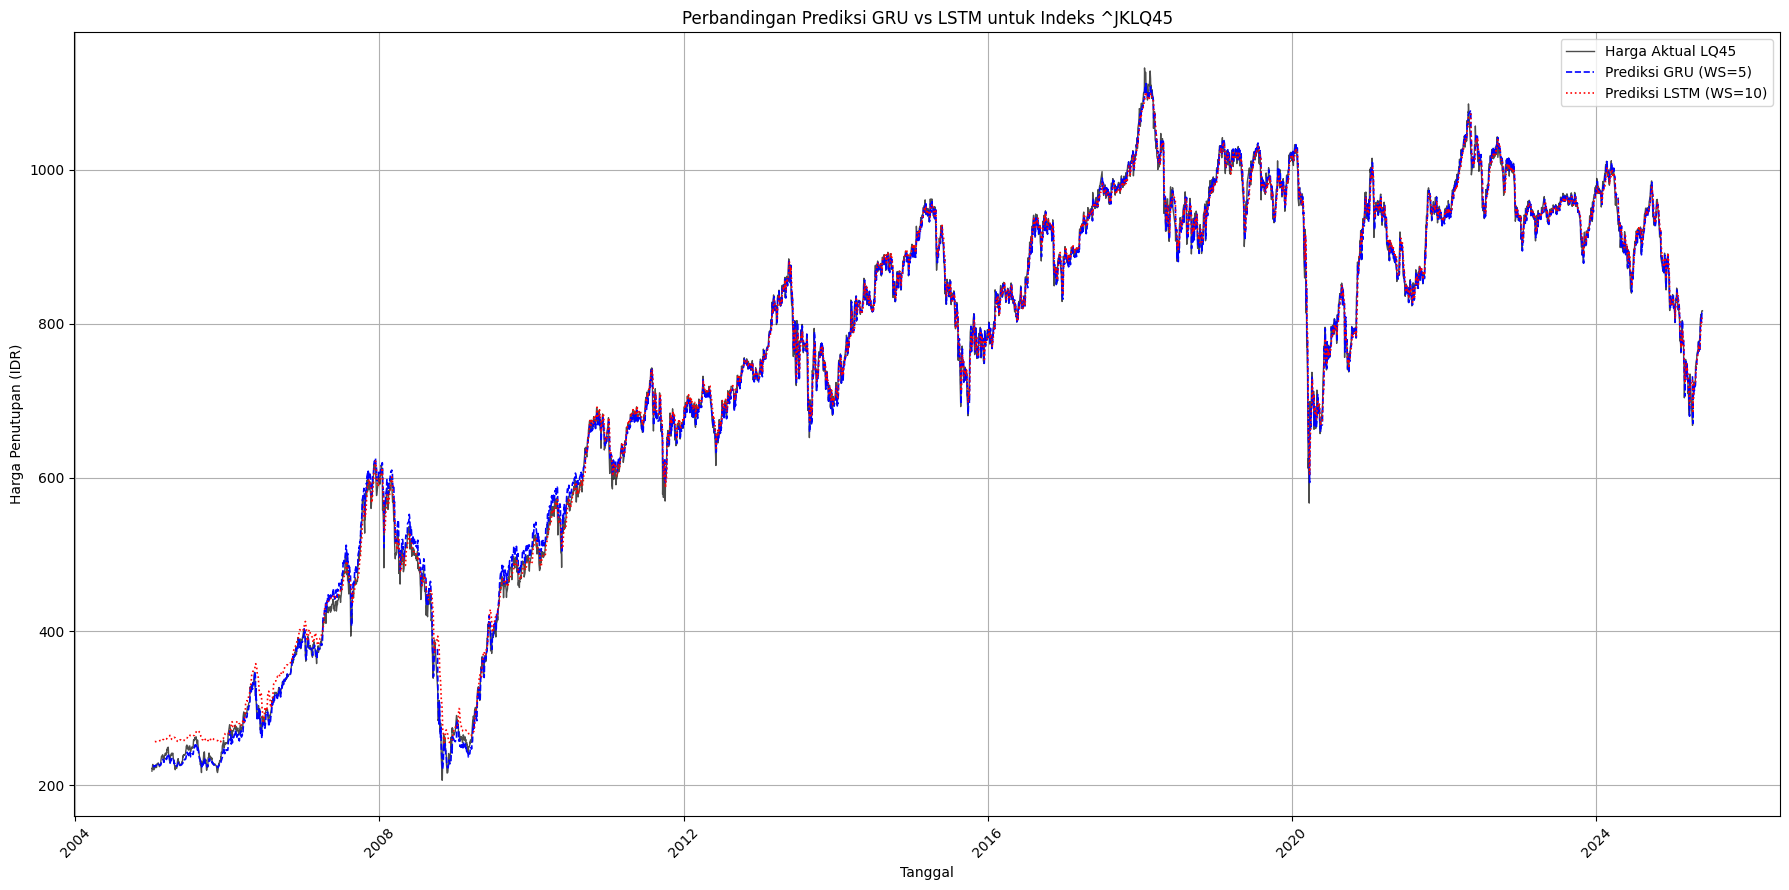

Eksekusi plot dan metrik selesai (jika ada data).


In [ ]:
# 4. Eksekusi Prediksi dan Plot

# --- Debugging Tambahan sebelum memanggil fungsi ---
print(f"Tipe GRUNet global sebelum panggil fungsi: {type(GRUNet)}")
print(f"Tipe LSTMNet global sebelum panggil fungsi: {type(LSTMNet)}")
# -------------------------------------------------

# --- Dapatkan Prediksi GRU ---
gru_model_init_params = {
    'input_dim': N_FEATURES,
    'hidden_gru_dims_list': GRU_UNITS_LIST,
    'hidden_dense_dim': GRU_DENSE_UNITS,
    'output_dim': 1,
    'dropout_p': GRU_DROPOUT_RATE
}
dates_gru, actual_gru, preds_gru, scaler_gru = None, None, None, None
# Coba muat model GRU
try:
    dates_gru, actual_gru, preds_gru, scaler_gru = get_predictions_for_model(
        "GRU", KODE_INDEKS, PERIODE_AWAL_DATA, PERIODE_AKHIR_DATA,
        GRU_WINDOW_SIZE, TRAIN_RATIO,
        GRUNet,  # Lewatkan objek kelas GRUNet
        gru_model_init_params,
        GRU_MODEL_FILENAME,
        N_FEATURES, device, output_dir_pt
    )
except Exception as e:
    print(f"Error saat memproses model GRU: {e}")


# --- Dapatkan Prediksi LSTM ---
lstm_model_init_params = {
    'input_dim': N_FEATURES,
    'hidden_lstm_dims_list': LSTM_UNITS_LIST,
    'hidden_dense_dim': LSTM_DENSE_UNITS,
    'output_dim': 1,
    'dropout_p': LSTM_DROPOUT_RATE
}
dates_lstm, actual_lstm, preds_lstm, scaler_lstm = None, None, None, None
# Coba muat model LSTM
try:
    dates_lstm, actual_lstm, preds_lstm, scaler_lstm = get_predictions_for_model(
        "LSTM", KODE_INDEKS, PERIODE_AWAL_DATA, PERIODE_AKHIR_DATA,
        LSTM_WINDOW_SIZE, TRAIN_RATIO,
        LSTMNet, # Lewatkan objek kelas LSTMNet
        lstm_model_init_params,
        LSTM_MODEL_FILENAME,
        N_FEATURES, device, output_dir_pt
    )
except Exception as e:
    print(f"Error saat memproses model LSTM: {e}")


# --- Plot Perbandingan ---
# ... (Kode plot sama, pastikan cek None sebelum plot) ...
plt.figure(figsize=(18, 9))
# Plot data aktual hanya jika salah satu model berhasil dimuat
plot_actual_data = False
if dates_gru is not None or dates_lstm is not None:
    full_actual_data_plot = yf.download(KODE_INDEKS, start=PERIODE_AWAL_DATA, end=PERIODE_AKHIR_DATA, progress=False)[['Close']]
    full_actual_data_plot.dropna(inplace=True)
    plt.plot(full_actual_data_plot.index, full_actual_data_plot['Close'], label='Harga Aktual LQ45', color='black', linewidth=1, alpha=0.7)
    plot_actual_data = True

if dates_gru is not None and preds_gru is not None:
    plt.plot(dates_gru, preds_gru, label=f'Prediksi GRU (WS={GRU_WINDOW_SIZE})', color='blue', linestyle='--', linewidth=1.2)
if dates_lstm is not None and preds_lstm is not None:
    plt.plot(dates_lstm, preds_lstm, label=f'Prediksi LSTM (WS={LSTM_WINDOW_SIZE})', color='red', linestyle=':', linewidth=1.2)

if plot_actual_data: # Hanya tampilkan plot jika ada data
    plt.title(f'Perbandingan Prediksi GRU vs LSTM untuk Indeks {KODE_INDEKS}')
    plt.xlabel('Tanggal')
    plt.ylabel('Harga Penutupan (IDR)')
    plt.legend(); plt.grid(True); plt.xticks(rotation=45); plt.tight_layout(); plt.show()
else:
    print("Tidak ada data prediksi untuk diplot.")

# ... (Kode metrik sama, tambahkan pengecekan None) ...
if actual_gru is not None and preds_gru is not None:
    # ... perhitungan metrik GRU ...
    pass
if actual_lstm is not None and preds_lstm is not None:
    # ... perhitungan metrik LSTM ...
    pass

print("Eksekusi plot dan metrik selesai (jika ada data).")